# Outlier detection comparison

__Note__: to run the experiment and use
`import pycy_usporf` module

- Open `SPORF/Python/rerf` and download the following
files into your local computer
    - `pycy_usporf.py`

- Open `SPORF/Python/src` and download the following
files into your local computer
    - `cy_usporf.pyx` 
    - `setup.py`
- Open terminal, `cd` to the files location and run
    - ```terminal
$ python setup.py build_ext --inplace
```

In [1]:
%matplotlib inline

In [2]:
"""
==================================================
Benchmark performance of USPORF in 3D toy dataset
==================================================

This example compares the performance of isolarion forest (IF)
and USPORF on outlier detection with different 3D datasets.

Algorithms:
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- USPORF using distance matrix, `UnsupervisedRandomForest`
    - C++ backend, cannot extract trees structure
- Usporf using path length, `pycy_usporf.UForest`
    - Cython backend, can extract trees structure

Benchmarks
- Accuracy_score: top left of each data figure
- Computational time: bottom right of each data figure 
- AUC score: far right colum in ROC figures

"""
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import time
from sklearn.datasets import make_moons, make_blobs
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.ensemble import IsolationForest
from rerf.urerf import UnsupervisedRandomForest
import pycy_usporf 

##  Note: to run an example
# Download `pycy_usporf.py` and `cy_usporf.pyx` 
# into your local drive and generate `.so` module using `setup.py`

In [3]:
# Data parameter
d_noise = 5  # number of Gaussian dimensional noise
n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
line_sd = 0.06  # sd of the line in dataset 1 and 2
cluster_sd = 0.2  # sd of the cluster in dataset 4 and 5
noise_sd = 2  # sd of the cluster in dimensional noise

print("Experimental setup\n===================")
print("informative dimension = 5,\nnoise dimension = %d," %(d_noise))
print("sample size = %d,\noutlier fraction = %.2f" %(
    n_samples, outliers_fraction))

Experimental setup
informative dimension = 5,
noise dimension = 5,
sample size = 500,
outlier fraction = 0.15


In [4]:
# Define datasets
## 1: Linear
def fun_linear(samples=1, sd=0.0):
    t_lin = np.transpose(np.linspace(-1, 1, samples))
    X_lin = np.c_[
        0.4 * t_lin + sd * np.random.randn(samples),
        0.6 * t_lin + sd * np.random.randn(samples),
        t_lin + sd * np.random.randn(samples),
    ]
    return X_lin


X_lin = fun_linear(samples=n_inliers, sd=line_sd)

## 2: Helix
def fun_helix(samples=1, sd=0.0):
    t_hex = np.transpose(np.linspace(2 * np.pi, 9 * np.pi, samples))
    xline = t_hex * np.cos(t_hex)  # before rescale
    xline = xline / (max(xline) - min(xline)) * 2 + sd * np.random.randn(samples)
    yline = t_hex * np.sin(t_hex)  # before rescale
    yline = yline / (max(yline) - min(yline)) * 2 + sd * np.random.randn(samples)
    zline = (t_hex - (max(t_hex) + min(t_hex)) / 2) / (
        max(t_hex) - min(t_hex)
    ) * 2 + sd * np.random.randn(samples)
    X_hex = np.c_[xline, yline, zline]
    return X_hex


X_hex = fun_helix(samples=n_inliers, sd=line_sd)

## 3: Sphere, equally distribution
def fibonacci_sphere(samples=1, randomize=True):
    rnd = 1.0
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2.0 / samples
    increment = np.pi * (3.0 - np.sqrt(5.0))
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x, y, z])
    return points


X_sph = np.array(fibonacci_sphere(samples=n_inliers))

## 4: Gaussian Mixture
def gaussian_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_gau = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0, 0, 0], [0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_gau


X_gau = gaussian_blobs(samples=n_inliers, sd=cluster_sd)

## 5: Misaligned Gaussian Mixture
def misaligned_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_misaligned = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0.7, 0.7, -0.7], [-0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_misaligned


X_misaligned = misaligned_blobs(samples=n_inliers, sd=cluster_sd)

## 6: Whole dataset
datasets3D = [X_lin, X_hex, X_sph, X_gau, X_misaligned]

# define to data label: y_true
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)
# label 1 as inliers, -1 as outliers

In [5]:
# Define algorithms
anomaly_algorithms = [
    ("IF", IsolationForest(contamination=outliers_fraction,
                           random_state=42)),
    ("Usporf_distance", UnsupervisedRandomForest(n_estimators=100, random_state=0)),
    ("Usporf_depth_cy", pycy_usporf.UForest(n_estimators=100)),
]

In [6]:
# related functions

def mat_to_score(mat, power =2):
    s = (mat**power).sum(axis=1)/mat.shape[0]
    return s

def decision_function(s_train, s_test, less_inlier = True): # array
    if s_test is None:
        s_test=s_train
    if less_inlier == True: 
        s_train = s_train
        s_test = s_test
    if less_inlier == False: 
        s_train = -s_train
        s_test = -s_test
    offset_ = np.percentile(s_train, outliers_fraction*100)
    decision_function = s_test - offset_
    return decision_function
    
def OutPredict(decision_function):
    is_inlier = np.ones(decision_function.shape[0], dtype=int)
    is_inlier[decision_function <= 0] = -1
    return is_inlier

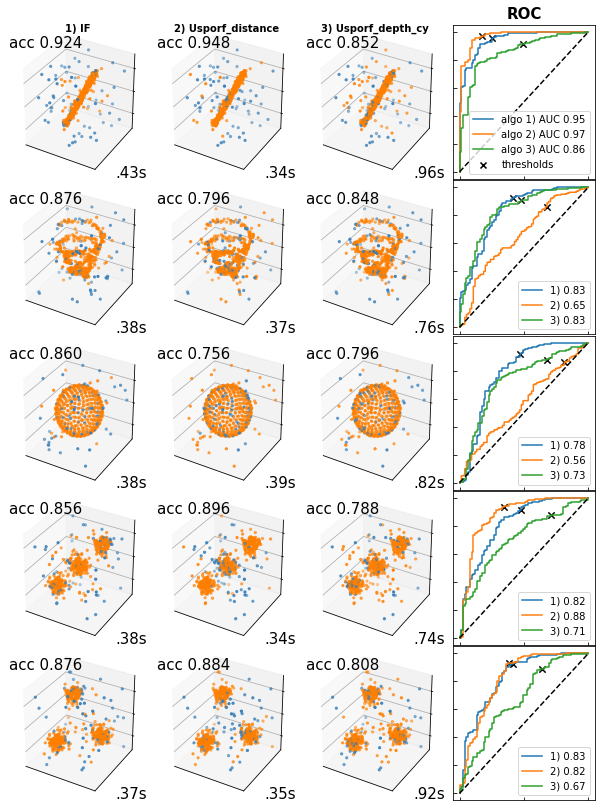

In [7]:
# Plot
plt.figure(figsize=((len(anomaly_algorithms)) * 2.5 + 1, len(datasets3D) * 2 + 1))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.98, wspace=0.05, hspace=0.01
)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset3D, X in enumerate(datasets3D):
    # add uniform distribution outliers
    X = np.concatenate([X, rng.uniform(low=-1.5, high=1.5, size=(n_outliers, 3))], axis=0)
    # add Gaussian dimensional noise, set the center at origin
    X = np.concatenate([X, 14.*(np.random.RandomState(42).rand(n_samples, d_noise))], axis=1)

    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []


    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X) 

        # predict outlier
        if name == "Usporf_distance":
            d_sim = algorithm.transform()
            s = mat_to_score(mat=d_sim)
            probas_ = decision_function(s_train=s, s_test=s, less_inlier= True)
            y_pred = OutPredict(decision_function=probas_)
        elif name == "Usporf_depth" or name == "Usporf_depth_cy":
            s = algorithm.compute_paths(X)
            probas_ = decision_function(s_train=s, s_test=s, less_inlier= False)
            y_pred = OutPredict(decision_function=probas_)
        else:
            probas_ = algorithm.fit(X).decision_function(X)
            y_pred = algorithm.predict(X)

        AUC = roc_auc_score(y_true, probas_)
        fpr, tpr, thresholds = roc_curve(y_true, probas_)
        thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]
        # store ROC curve
        list_AUC.append(AUC)
        list_fpr.append(fpr)
        list_tpr.append(tpr)
        list_thresh.append(thresh_index)
        
        
        # compute the accuracy
        acc = accuracy_score(y_true, y_pred)
        t1 = time.time()
        
        # add data plot
        ax = plt.subplot(
            len(datasets3D), len(anomaly_algorithms)+1, plot_num, projection="3d"
        )
        ax.axis("on")
        if i_dataset3D == 0:
            plt.title(
                str(algo_index + 1) + ") " + name, size=10, color="black", weight="bold"
            )  # use function's name for a title
        colors = np.array(["#377eb8", "#ff7f00"])
        # color plot ('blue' = outlier, 'orange'=inlier)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=5, color=colors[((y_pred + 1) // 2)])
        ax.text2D(
            0.01,
            0.85,
            ("acc %.3f" % acc).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="left",
        )
        ax.text2D(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.zaxis.set_ticklabels([])
        algo_index += 1
        plot_num += 1
        
#------------------------------------------------------    
# plot the ROC curves and show AUC scores

    plt.subplot(len(datasets3D), len(anomaly_algorithms) + 1, plot_num) # +1 for ROC column

    if i_dataset3D == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        
        # lebel the decision_function's thresholds
        plt.scatter([], [], marker="x", color="black", label="thresholds")
        
    for algo_index in range(len(anomaly_algorithms)):
        
        if i_dataset3D == 0:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label="algo " + str(algo_index + 1)+ ")"
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"))
        else:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label= str(algo_index + 1)+ ")"
                + (" %.2f" % list_AUC[algo_index]).lstrip("0"))

        plt.scatter(
        list_fpr[algo_index][list_thresh[algo_index]],
        list_tpr[algo_index][list_thresh[algo_index]],
        s=40, marker="x", color = 'black')

    plt.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    plt.legend()
    plt.tick_params(labelleft = False, labelbottom = False, direction  = "in")
    plot_num += 1  

plt.show()